imports

In [1]:
import torch
import os
import numpy as np
from tqdm import tqdm

import pandas as pd

from myhelpers import cifar_dataLoader

from HGNN.train.configParser import ConfigParser
from HGNN.train import CNN, dataLoader
from myhelpers.memory import get_cuda_memory

experimetnsFileName = "experiments.csv"

parameters

In [2]:
experimentsPath="/raid/elhamod/CIFAR_HGNN/experiments/"
dataPath="/raid/elhamod/"
experimentName="CIFAR_phylogeny_from_scratch_2"#"CIFAR_phylogeny_HGNN_lambdaExperiment"
trial_hash="57b3047e0369751612772f9d1386952a3d568e2414fb082dc93ace99"#"43685e27da0ec8febf221e2679a93761a6a51db65bc4571838fd4404"

cuda=1
batch_size = 128
num_workers = 8

cuda

In [3]:
# set cuda
if torch.cuda.is_available():
    torch.cuda.set_device(cuda)
    print("using cuda", cuda)
    
torch.multiprocessing.set_start_method('spawn')

using cuda 1


Get dataset

In [4]:
# Get experiment parameters
experimentsFileNameAndPath = os.path.join(experimentsPath, experimetnsFileName)
if os.path.exists(experimentsFileNameAndPath):
    experiments_df = pd.read_csv(experimentsFileNameAndPath)
    experiments_df = experiments_df.where(pd.notnull(experiments_df), None)
else:
    raise Exception("Experiment not " + trial_hash + " found!")
experimentRecord = experiments_df[experiments_df["trialHash"] == trial_hash]
experiment_params = experimentRecord.to_dict('records')[0]
print(experiment_params)

config_parser = ConfigParser(experimentsPath, dataPath, experimentName)
experimentPathAndName = os.path.join(experimentsPath, experimentName)
if experiment_params['image_path'] == 'cifar-100-python':
    datasetManager = cifar_dataLoader.datasetManager(experimentPathAndName, dataPath)
else:
    datasetManager = dataLoader.datasetManager(experimentPathAndName, dataPath)
datasetManager.updateParams(config_parser.fixPaths(experiment_params))
train_dataset, test_dataset = datasetManager.getDataset()
train_loader, validation_loader, test_loader = datasetManager.getLoaders()

dataset = test_loader.dataset

{'experimentName': 'CIFAR_phylogeny_from_scratch_2', 'modelName': 'models/57b3047e0369751612772f9d1386952a3d568e2414fb082dc93ace99', 'datasetName': 'datasplits/dd10c35154ee995db5de0276a21ca1a15a77964ee53811d98f089e89', 'experimentHash': '633a6e6b80451ee8269e24f7d63932427486c38c6f8f273e828f9251', 'trialHash': '57b3047e0369751612772f9d1386952a3d568e2414fb082dc93ace99', 'image_path': 'cifar-100-python', 'suffix': None, 'img_res': 32, 'augmented': True, 'batchSize': 32, 'learning_rate': 0.1, 'numOfTrials': 1, 'fc_layers': 1, 'modelType': 'BB', 'lambda': 10.0, 'unsupervisedOnTest': None, 'tl_model': 'preResNet', 'link_layer': 'avgpool', 'adaptive_smoothing': True, 'adaptive_lambda': 0.1, 'adaptive_alpha': 0.1, 'noSpeciesBackprop': False, 'phylogeny_loss': 'False', 'phylogeny_loss_epsilon': 0.03, 'tripletEnabled': True, 'tripletSamples': 3.0, 'tripletSelector': 'semihard', 'tripletMargin': 0.2, 'displayName': 'CIFAR preresnet from scratch triplet', 'adaptive_alphalambda': None, 'pretrained':

Get untrained model

In [5]:
architecture = {
    "fine": len(dataset.csv_processor.getFineList()),
    "coarse" : len(dataset.csv_processor.getCoarseList())
}
model = CNN.create_model(architecture, experiment_params, cuda)

# get the model and the parameters
modelName = experimentRecord.iloc[0]["modelName"]
trialName = os.path.join(experimentPathAndName, modelName)
_ = CNN.loadModel(model, trialName)
model.eval()

layer4 not found
Model loaded into cpu!


CNN_One_Net_Triplet_Wrapper(
  (network_fine): CNN_One_Net(
    (pretrained): resnet(
      (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
        )
        (1): Bottleneck(
          (bn1): Bat

In [6]:
predProblist_, lbllist = CNN.getLoaderPredictionProbabilities(test_loader, model, experiment_params, device=cuda)

transform test False
[ToTensor(), Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])]
---


sort through predictions

In [7]:
def get_classification_df(predProblist_, lbllist, modelName, experimentPathAndName):

    df_misclassified = pd.DataFrame(columns=['file name', 'true label', 'probability of true label', 'predicted label'])
    df_correctlyclassified = pd.DataFrame(columns=['file name', 'true label', 'probability of true label', 'predicted label'])

    # get probability of correct prediction and true label
    
    _, predlist = torch.max(predProblist_, 1)
    lbllist = lbllist.reshape(lbllist.shape[0], -1)
    predProblist = predProblist_.gather(1, lbllist)
    predProblist = predProblist.reshape(1, -1)
    predProblist = predProblist[0]

    # sort through
    predProblist, indices = torch.sort(predProblist)
    predlist = predlist[indices]
    lbllist = lbllist[indices]

    for i, lbl in tqdm(enumerate(lbllist), total=len(lbllist)):
        prd = predlist[i]
        prdProb = predProblist[i]

        if torch.cuda.is_available():
            lbl = lbl.cpu()
            prd = prd.cpu()
            prdProb = prdProb.cpu()

        s = dataset[indices[i]]
        row = {'file name' : s['fileName'] , 
               'true label' : int(lbl.numpy()), 
               'probability of true label': float(prdProb.numpy()),
               'predicted label' : int(prd.numpy()),
              'original_index': int(indices[i])}

        if(lbl != prd):
            df_misclassified = df_misclassified.append(row, ignore_index=True)
        else:
            df_correctlyclassified = df_correctlyclassified.append(row, ignore_index=True)


    df_misclassified = df_misclassified.sort_values(by=[ 'true label', 'probability of true label'])
    df_correctlyclassified = df_correctlyclassified.sort_values(by=['true label', 'probability of true label'])
    
    df_misclassified.to_csv(os.path.join(experimentPathAndName, modelName, 'misclassified examples.csv'))
    df_correctlyclassified.to_csv(os.path.join(experimentPathAndName, modelName, 'correctly classified examples.csv'))
    
    return df_misclassified, df_correctlyclassified

In [8]:
df_misclassified, df_correctlyclassified = get_classification_df(predProblist_, lbllist, modelName, experimentPathAndName)

100%|██████████| 10000/10000 [00:47<00:00, 210.43it/s]


Display and save mispredicted

In [9]:
df_misclassified

,file name,true label,probability of true label,predicted label,original_index
232,b'mcintosh_s_000330.png',0,0.001225,78,4676.0
448,b'macoun_s_000479.png',0,0.002701,57,8019.0
1029,b'crabapple_s_000465.png',0,0.010408,53,4760.0
1039,b'mcintosh_s_000692.png',0,0.010549,22,4666.0
1469,b'pearmain_s_000136.png',0,0.021084,25,235.0
...,...,...,...,...,...
2712,b'tapeworm_s_000001.png',99,0.131440,26,2596.0
3027,b'nematode_worm_s_000484.png',99,0.198978,69,9423.0
3071,b'worm_s_000954.png',99,0.211037,18,2625.0
3211,b'schistosome_s_000127.png',99,0.265693,10,2263.0


Filename of correctly classified

In [10]:
df_correctlyclassified

,file name,true label,probability of true label,predicted label,original_index
524,b'red_delicious_s_000741.png',0,0.492448,0,5807.0
1055,b'eating_apple_s_000297.png',0,0.646372,0,226.0
1330,b'macoun_s_001022.png',0,0.719635,0,623.0
1585,b'apple_s_000022.png',0,0.777111,0,4144.0
1737,b'eating_apple_s_000618.png',0,0.802926,0,9097.0
...,...,...,...,...,...
6332,b'nematode_s_001819.png',99,0.991821,99,1955.0
6345,b'enterobius_vermicularis_s_000209.png',99,0.992107,99,1895.0
6356,b'nematode_s_000871.png',99,0.992332,99,4054.0
6373,b'tapeworm_s_000669.png',99,0.992668,99,3277.0


In [11]:
import matplotlib.pyplot as plt
import torchvision as tv

def imshow(img):
    img = img / 2 + 0.5   # unnormalize
    npimg = img.numpy()   # convert from tensor
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show()
    
def showExample(dataset, index, predictions):    
    prediction = predictions[index, :]
    entry =dataset[index]
    imshow(tv.utils.make_grid(entry['image']))
    fileName = entry['fileName']
    truth_fine = dataset.csv_processor.getFineList()[entry['fine']]
    truth_coarse = dataset.csv_processor.getCoarseList()[entry['coarse']]
    print('File name', fileName)
    print('Truth', truth_fine, truth_coarse)
    print('Sorted predictions')
    df = pd.DataFrame(columns=["Top", "fine label", "coarse label", "model's prob of fine label"])
    prediction_sorted, prediction_indices = torch.sort(prediction, descending=True)
    for i, pred in enumerate(prediction_sorted):
        pred_fine = dataset.csv_processor.getFineList()[prediction_indices[i].item()]
        pred_coarse = dataset.csv_processor.getCoarseFromFine(pred_fine)
        pred_prob = pred.item()
        df = df.append({
         "Top": i,
         "fine label":  pred_fine,
         "coarse label":  pred_coarse,
         "model's prob of fine label":  pred_prob,
        }, ignore_index=True)
    return df

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


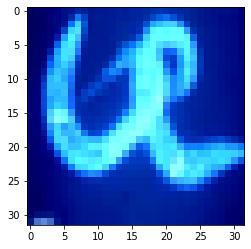

File name b'nematode_s_001376.png'
Truth worm b'non-insect_invertebrates'
Sorted predictions


,Top,fine label,coarse label,model's prob of fine label
0,0,worm,b'non-insect_invertebrates',0.872234
1,1,ray,b'fish',0.048396
2,2,shark,b'fish',0.024279
3,3,snake,b'reptiles',0.005826
4,4,whale,b'aquatic_mammals',0.003540
...,...,...,...,...
95,95,streetcar,b'vehicles_2',0.000027
96,96,girl,b'people',0.000027
97,97,house,b'large_man-made_outdoor_things',0.000026
98,98,castle,b'large_man-made_outdoor_things',0.000022


In [12]:
original_index = 9300
showExample(dataset, original_index, predProblist_)

In [15]:
# given a dataset, a model, an activation name, and an input, find K the closest image in that space

def getClosestImageFromDataset(dataset, model, activation_layer, image, topk=2):   
#     model = model.pretrained
    dist_func = torch.nn.MSELoss(reduction='none')
    hist_list = []
    
    f, axarr = plt.subplots(1,topk, squeeze=False)
    
    # get loader
    loader = torch.utils.data.DataLoader(dataset, pin_memory=True, batch_size=batch_size, num_workers=num_workers)
    
    if cuda:
        image = image.cuda()
    
    # get activation of image
    features = model(image)[activation_layer]
    distance = None
    
    # loop through loader
    for i, batch in tqdm(enumerate(loader), total=len(loader)):
        image2 = batch['image']
        if cuda:
            image2 = image2.cuda()
        features2 = model(image2)[activation_layer]
    
        # Calculate distance for each pair.
        temp = torch.sqrt(torch.sum(dist_func(torch.cat(features2.shape[0]*[features]), features2).detach(), 1))
        distance =  temp if distance is None else torch.cat([distance, temp]) 
    
    if cuda:
        distance = distance.cpu()
    hist_list = list(distance.numpy()) 
    distance = distance.reshape(-1)
    inv_distance = 1/distance
    
    _, topk_distances_indices = inv_distance.topk(topk, 0, True, True)
    
    # print information about best one
    a, n, _ = loader.dataset.toggle_image_loading(dataset.augmentation_enabled, False)
    for k, index in enumerate(topk_distances_indices):
        batch = dataset[index]
        img = batch['image']# / 2 + 0.5   # unnormalize
        npimg = img.numpy()   # convert from tensor
        axarr[0,k].imshow(np.transpose(npimg, (1, 2, 0)))
        fileName = batch['fileName']
        fineName = dataset.csv_processor.getFineList()[batch['fine']]
        coarseName = dataset.csv_processor.getCoarseList()[batch['coarse']]
        d = distance[index].item()

        string = fileName + "\n"
        string = string + fineName + "\n"
        string = string + coarseName + "\n"
        string = string +"d = " + str(round(d, 2))
        axarr[0, k].set_title(string)
        
    loader.dataset.toggle_image_loading(a, n)

    plt.figure()
    plt.hist(hist_list, 20)
    plt.title("Histogram of distances")
    

100%|██████████| 79/79 [00:05<00:00, 13.40it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


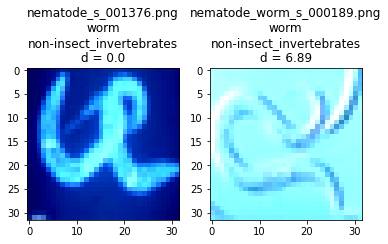

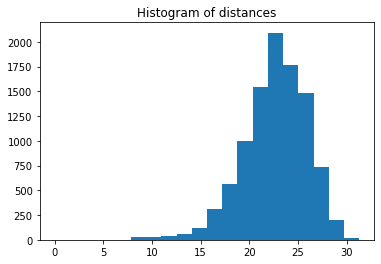

In [16]:
# getClosestImageFromDataset(dataset, model, 'fine', dataset[original_index]['image'].unsqueeze(0))
getClosestImageFromDataset(dataset, model, 'fine', dataset[original_index]['image'].unsqueeze(0))

In [23]:
activation_layer = 'fine'
import numpy as np
from sklearn.manifold import TSNE
from torchvision import transforms



X = None
for i, batch in tqdm(enumerate(test_loader), total=len(test_loader)):
    image2 = batch['image']
    if cuda:
        image2 = image2.cuda()
    features2 = model(image2)[activation_layer].detach().cpu()

    # Calculate distance for each pair.
    X = features2 if X is None else torch.cat([X, features2]).detach()
tsne = TSNE(n_components=2, learning_rate=150, perplexity=30, angle=0.2, verbose=2).fit_transform(X)


tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))







100%|██████████| 313/313 [00:15<00:00, 20.30it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.118s...
[t-SNE] Computed neighbors for 10000 samples in 17.444s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 3.152670
[t-SNE] Computed conditional probabilities in 0.486s
[t-SNE] Iteration 50: error = 97.2130280, gradient norm = 0.0033495 (50 iterations in 2.250s)
[t-SNE] I

NameError: name 'matplotlib' is not defined

In [31]:
images = None

a, n = test_loader.dataset.toggle_image_loading(test_loader.dataset.augmentation_enabled, False)
for i, batch in tqdm(enumerate(test_loader), total=len(test_loader)):
    image2 = batch['image']
    images = image2 if images is None else torch.cat([images, image2]).detach()
    
test_loader.dataset.toggle_image_loading(a, n)

  5%|▌         | 16/313 [00:00<00:01, 159.08it/s]

test False
transform test False
[ToTensor()]
---


100%|██████████| 313/313 [00:04<00:00, 64.85it/s] 

test False


(False, False)

In [34]:
from PIL import Image

width = 8000
height = 6000
max_dim = 100

full_image = Image.new('RGB', (width, height))
for img, x, y in zip(images, tx, ty):
#     tile = Image.open(img)
    tile = transforms.ToPILImage()(img).convert("RGB")
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

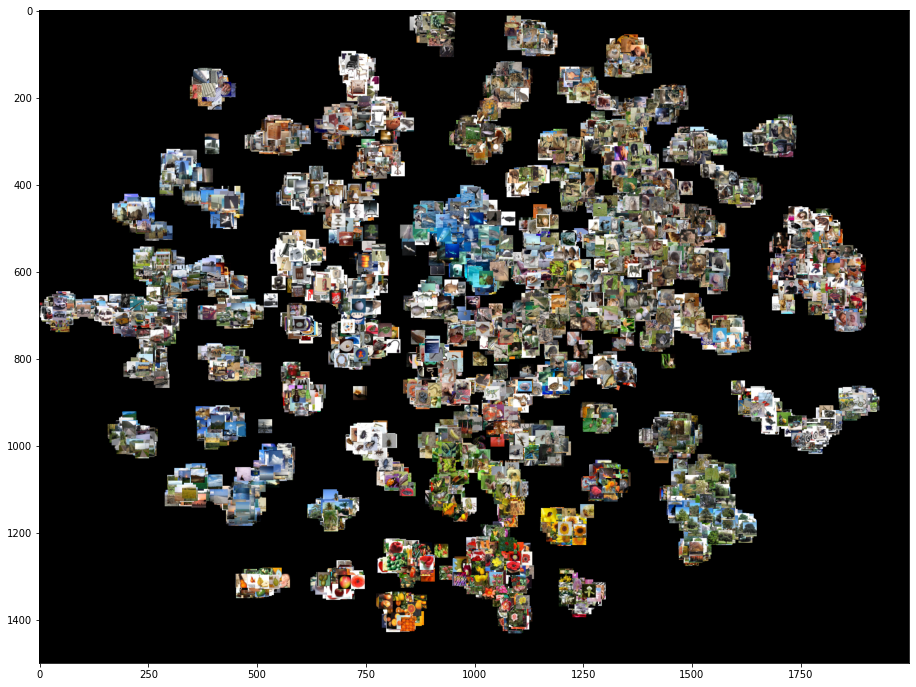

In [35]:
import matplotlib
from matplotlib.pyplot import imshow

matplotlib.pyplot.figure(figsize = (16,12))
imshow(full_image)
full_image.save("deleteme.jpg")